In [1]:
import typing
from typing import Any, Tuple

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [2]:
use_builtins = True

In [3]:
class ShapeChecker:
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(
                f'Rank mismatch:\n'
                f'  Found {rank}: {shape.numpy()}\n'
                f'  Expected {len(names)}: {names}'
            )

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name

            else:
                old_dim = self.shapes.get(name, None)

            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(
                    f'Shape mismatch for dimension: "{name}"\n'
                    f'  Found: {new_dim}\n'
                    f'  Expected: {old_dim}'
                )

In [5]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2638744/2638744 [==============================] - 0s 0us/step


In [6]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]
    return targ, inp

In [7]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [8]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [9]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [10]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Pesa solo 3 kilos.' b'Si dices la verdad no tienes que recordar nada.'
 b'\xc2\xbfD\xc3\xb3nde estabas?, te estuvimos buscando por todos lados.'
 b'\xc2\xbfCu\xc3\xa1nta televisi\xc3\xb3n ves?'
 b'\xc2\xbfTienes hermanos menores?'], shape=(5,), dtype=string)
tf.Tensor(
[b'It only weighs 3 kilograms.'
 b"If you tell the truth, you don't have to remember anything."
 b"Where were you? We've been looking all over for you."
 b'How much TV do you watch?' b'Do you have younger brothers?'], shape=(5,), dtype=string)


In [12]:
def tf_lower_and_split_punct(text):
    # Split accented characters
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)

    # Keep space, a to z, and select punctuation
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')

    # Add spaces around punctuation
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')

    # Strip whitespaces
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [14]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

In [15]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [16]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [17]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2, 3247,   62, 3579,    4,    3,    0,    0,    0,    0],
       [   2,   45, 1287,   11,  109,    9,   91,    5, 1017,   69],
       [   2,   13,   71,  534,   12,   19,   30, 2168,  432,   21]],
      dtype=int64)>

In [18]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] pesa solo kilos . [END]            '

Text(0.5, 1.0, 'Mask')

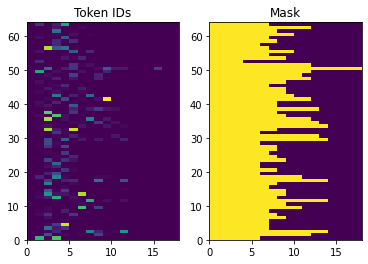

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [20]:
embedding_dim = 256
units = 1024

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.input_vocab_size,
            embedding_dim
        )

        # The GRU RNN layer processes those vectors sequentially
        self.gru = tf.keras.layers.GRU(
            self.enc_units,

            # Return the sequence and state
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        # The embedding layer looks up the embedding for each token
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # The GRU processes the embedding sequence:
            # Output shape: (batch, s, enc_units)
            # State shape: (batch, enc_units)

        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        # Returns the new sequence and its state
        return output, state

In [22]:
# Convert the input text to tokens
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence
encoder = Encoder(
    input_text_processor.vocabulary_size(),
    embedding_dim,
    units
)

example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 18)
Encoder output, shape (batch, s, units): (64, 18, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        
        # For Eqn. (4), the Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        # From Eqn. (4), `W1 @ ht`
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        # From Eqn. (4), `W2 @ hs`
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True
        )

        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(units)

In [25]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

print(f'Attention result shape, (batch_size, query_seq_length, units): {context_vector.shape}')
print(f'Attention weights shape, (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape, (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape, (batch_size, query_seq_length, value_seq_length): (64, 2, 18)


Text(0.5, 1.0, 'Mask')

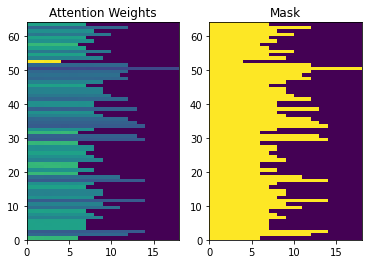

In [26]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention Weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [27]:
attention_weights.shape

TensorShape([64, 2, 18])

In [28]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

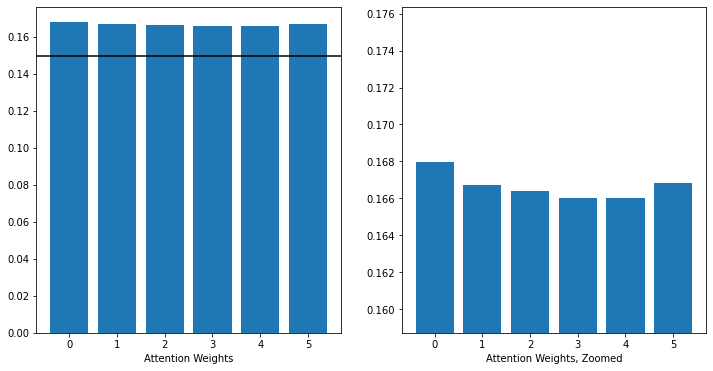

In [31]:
plt.suptitle('Attention Weights for One Sequence')
plt.figure(figsize=(12, 6))

a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)

# Freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention Weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention Weights, Zoomed')

# Zoom in
top = max(a1.get_ylim())
zoom = 0.85 * top

a2.set_ylim([0.90 * top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [32]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.output_vocab_size,
            embedding_dim
        )

        # The RNN keeps track of wath's been generated so far
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

        # The RNN output will be the query for the attention layer
        self.attention = BahdanauAttention(self.dec_units)

        # Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(
            dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )

        # This fullly connected layer produces the logits for each output token
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [34]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [36]:
def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))

    # Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)
    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Use the RNN output as the query for the attention over the encoder output
    context_vector, attention_weights =  self.attention(
        query=rnn_output,
        value=inputs.enc_output,
        mask=inputs.mask
    )

    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Eqn. (3): Join the `context_vector` and `rnn_output` [ct; ht] shape: (batch, t, values_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Eqn. (3): `at = tanh(Wc @ [ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Generate logit predictions
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [37]:
Decoder.call = call

In [38]:
decoder = Decoder(
    output_text_processor.vocabulary_size(),
    embedding_dim,
    units
)

In [40]:
# Convert the target sequence, and collect the `[START]` tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [41]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=(example_tokens != 0)
    ),

    state=example_enc_state
)

print(f'Logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'State shape: (batch_size, dec_units) {dec_state.shape}')

Logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
State shape: (batch_size, dec_units) (64, 1024)


In [42]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [43]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['court'],
       ['bothered'],
       ['required'],
       ['harder'],
       ['close']], dtype='<U16')

In [44]:
dec_result, dec_state = decoder(
    DecoderInput(
        sampled_token,
        example_enc_output,
        mask=(example_tokens != 0)
    ),

    state=dec_state
)

In [45]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['singing'],
       ['arm'],
       ['panicked'],
       ['threat'],
       ['shore']], dtype='<U16')

In [46]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'

        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction='none'
        )

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        # Calculate the loss for each item in the batch
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # Mask off the losses on padding
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))

        loss *= mask

        # Return the total
        return tf.reduce_sum(loss)

In [47]:
class TrainTranslator(tf.keras.Model):
    def __init__(
        self,
        embedding_dim,
        units,
        input_text_processor,
        output_text_processor,
        use_tf_function=True
    ):
        super().__init__()

        # Build the encoder and decoder
        encoder = Encoder(
            input_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )

        decoder = Decoder(
            output_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()

        if self.use_tf_function:
            return self._tf_train_step(inputs)

        else:
            return self._train_step(inputs)

In [48]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to tokens IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask

In [49]:
TrainTranslator._preprocess = _preprocess

In [50]:
def _train_step(self, inputs):
    input_text, target_text = inputs

    (
        input_tokens,
        input_mask,
        target_tokens,
        target_mask
    ) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))

        # Initialize the decoder's state to the encoder's final state. This only works if the encoder and decoder have the same number of units
        dec_state = enc_state

        loss = tf.constant(0.0)

        for t in tf.range(max_target_length - 1):
            # Pass in two tokens from the target sequence:
                # 1. The current input for the decoder
                # 2. The target for the decoder's next prediction

            new_tokens = target_tokens[:, t:t + 2]

            step_loss, dec_state = self._loop_step(
                new_tokens,
                input_mask,
                enc_output,
                dec_state
            )

            loss = loss + step_loss

        # Average the loss over all non padding tokens
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [51]:
TrainTranslator._train_step = _train_step

In [57]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step
    decoder_input = DecoderInput(
        new_tokens=input_token,
        enc_output=enc_output,
        mask=input_mask
    )

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [58]:
TrainTranslator._loop_step = _loop_step

In [59]:
translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False
)

translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

In [60]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [61]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.608891>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5779257>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5187974>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.340493>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.64634>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.283746>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5779>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.39899>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.191032>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.017504>}
CPU times: total: 6.45 s
Wall time: 6.7 s


In [62]:
@tf.function(
    input_signature=[[
        tf.TensorSpec(dtype=tf.string, shape=[None]),
        tf.TensorSpec(dtype=tf.string, shape=[None])
    ]]
)
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [63]:
TrainTranslator._tf_train_step = _tf_train_step

In [64]:
translator.use_tf_function = True

In [65]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.951174>}

In [66]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.976483>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9648>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8694038>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.801565>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7929895>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7502522>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7045324>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.676007>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.63483>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5960221>}
CPU times: total: 4.72 s
Wall time: 2.77 s


....................................................................................................

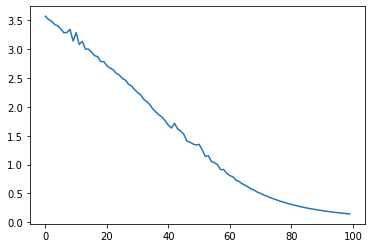

In [67]:
losses = []

for n in range(100):
    print('.', end='')

    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())

plt.plot(losses)

In [68]:
train_translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)

train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

In [69]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [70]:
train_translator.fit(dataset, epochs=3, callbacks=[batch_loss])

Epoch 1/3
1859/1859 [==============================] - 681s 363ms/step - batch_loss: 2.0381
Epoch 2/3
1859/1859 [==============================] - 706s 380ms/step - batch_loss: 1.0387
Epoch 3/3
1859/1859 [==============================] - 814s 438ms/step - batch_loss: 0.8068


Text(0, 0.5, 'CE/token')

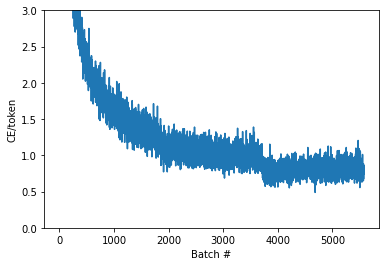

In [72]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [73]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True
            )
        )

        # The output should never generate padding, unknown, or start
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token=''
        )

        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

In [74]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)

C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3072136170.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


In [75]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))

    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')
    shape_checker(result_text, ('batch'))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))

    return result_text

In [76]:
Translator.tokens_to_text = tokens_to_text

In [77]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2],
    minval=0,
    dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size()
)

translator.tokens_to_text(example_output_tokens).numpy()

array([b'feet cheerful', b'witty backyard', b'avoiding supplied',
       b'affect plant', b'promising staff'], dtype=object)

In [78]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab'))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so the are never chosen
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)

    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits / temperature, num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))
    return new_tokens

In [79]:
Translator.sample = sample

In [80]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4475],
       [4385],
       [1378],
       [1874],
       [ 967]], dtype=int64)>

In [88]:
def translate_unrolled(
    self,
    input_text,
    *,
    max_length=50,
    return_attention=True,
    temperature=1.0
):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens,
            enc_output=enc_output,
            mask=(input_tokens != 0)
        )

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        attention.append(dec_result.attention_weights)
        new_tokens = self.sample(dec_result.logits, temperature)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)

        # Once a sequence is done it only produces 0-padding
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens.append(new_tokens)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Convert the list of generates token ids to a list of strings
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}

    else:
        return {'text': result_text}

In [89]:
Translator.translate = translate_unrolled

In [90]:
%%time
input_text = tf.constant([
    'Hace mucho frio aqui.', # It's really cold here.
    'Esta es mi vida.' # This is my life.
])

result = translator.translate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())

its very cold here .
this is my life .
CPU times: total: 156 ms
Wall time: 152 ms


In [91]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_trasnlate = tf_translate

In [92]:
%%time
result = translator.tf_trasnlate(input_text=input_text)

CPU times: total: 15.3 s
Wall time: 15.3 s


In [93]:
%%time
result = translator.tf_trasnlate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())

its very cold it comes here .
this is my life .
CPU times: total: 375 ms
Wall time: 365 ms


In [95]:
def translate_symbolic(
    self,
    input_text,
    *,
    max_length=50,
    return_attention=True,
    temperature=1.0
):
    shape_checker = ShapeChecker()
    shape_checker(input_text, ('batch'))

    batch_size = tf.shape(input_text)[0]

    # Encode the input
    input_tokens = self.input_text_processor(input_text)
    shape_checker(input_tokens, ('batch', 's'))

    enc_output, enc_state = self.encoder(input_tokens)
    shape_checker(enc_output, ('batch', 's', 'enc_units'))
    shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    shape_checker(new_tokens, ('batch', 't1'))

    # Initialize the accumulators
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)

    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    shape_checker(done, ('batch', 't1'))

    for t in tf.range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens,
            enc_output=enc_output,
            mask=(input_tokens != 0)
        )

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))

        attention = attention.write(t, dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)
        shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
        shape_checker(new_tokens, ('batch', 't1'))

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)

        # Once a sequence is done it only produces 0-padding
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generate tokens
        result_tokens = result_tokens.write(t, new_tokens)

        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings
    result_tokens = result_tokens.stack()
    shape_checker(result_tokens, ('t', 'batch', 't0'))

    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    shape_checker(result_tokens, ('batch', 't'))

    result_text = self.tokens_to_text(result_tokens)
    shape_checker(result_text, ('batch',))

    if return_attention:
        attention_stack = attention.stack()
        shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

        attention_stack = tf.squeeze(attention_stack, 2)
        shape_checker(attention_stack, ('t', 'batch', 's'))

        attention_stack = tf.transpose(attention_stack, [1, 0, 2])
        shape_checker(attention_stack, ('batch', 't', 's'))

        return {'text': result_text, 'attention': attention_stack}

    else:
        return {'text': result_text}

In [96]:
Translator.translate = translate_symbolic

In [97]:
%%time
result = translator.translate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())

it makes too cold here .
this is my life . .
CPU times: total: 188 ms
Wall time: 181 ms


In [98]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_trasnlate = tf_translate

In [99]:
%%time
result = translator.tf_trasnlate(input_text=input_text)

CPU times: total: 969 ms
Wall time: 958 ms


In [100]:
%%time
result = translator.tf_trasnlate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())

its very cold here .
this is my life .
CPU times: total: 109 ms
Wall time: 98 ms


In [101]:
a = result['attention'][0]
print(np.sum(a, axis=-1))

[1.         0.99999994 1.         1.         1.0000001  0.99999994]


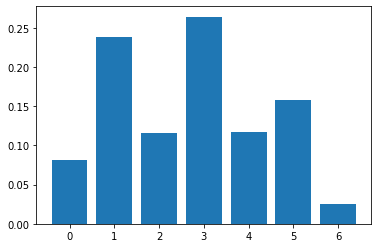

In [102]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

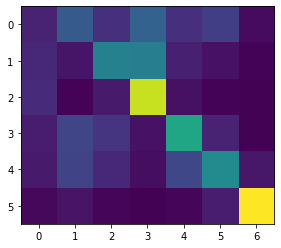

In [103]:
plt.imshow(np.array(a), vmin=0.0)

In [104]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input Text')
    ax.set_ylabel('Output Text')

    plt.suptitle('Attention Weights')

C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


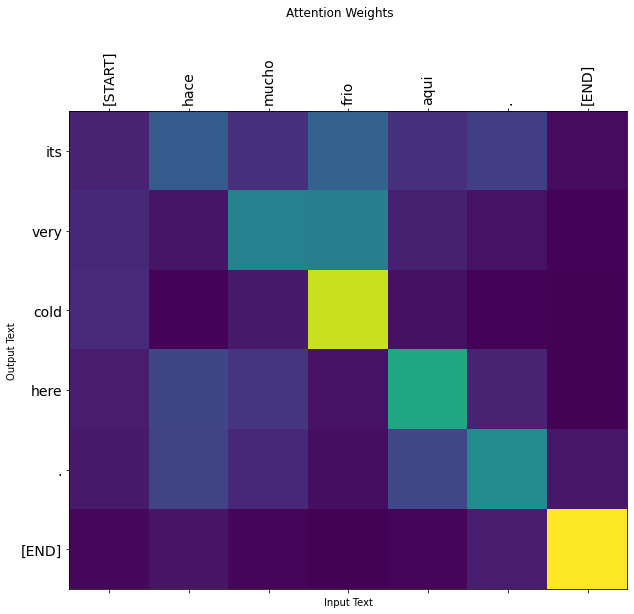

In [105]:
i = 0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [107]:
%%time
three_input_text = tf.constant([
    'Esta es mi vida.',
    '¿Todavía están en casa?',
    'Tratar de descubrir.'
])

result = translator.tf_trasnlate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

this is my life .
are they still at home ?
ill try ill agree .
CPU times: total: 141 ms
Wall time: 120 ms


In [108]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are they still at home ?',
       b'ill try ill agree .'], dtype=object)>

C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


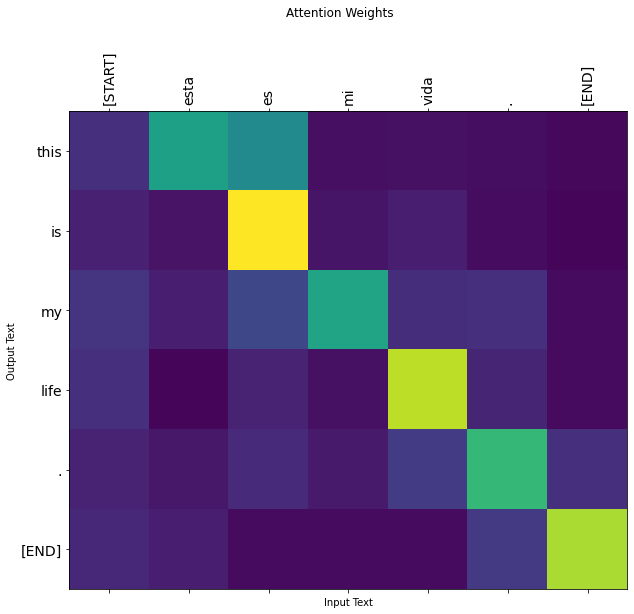

In [109]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


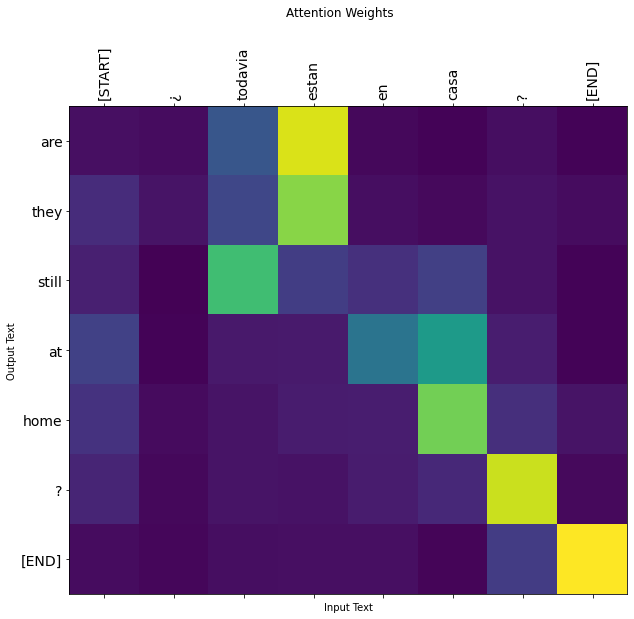

In [110]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


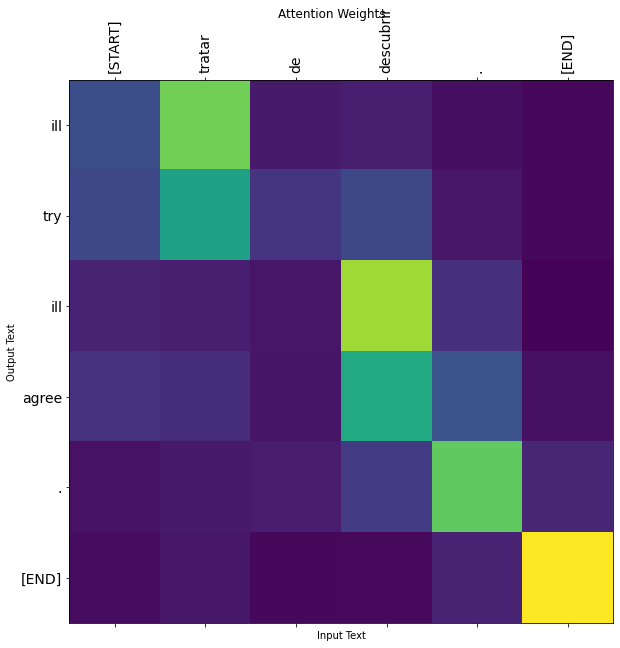

In [111]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [113]:
import textwrap

long_input_text = tf.constant([inp[-1]])
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\luisc\AppData\Local\Temp\ipykernel_7788\3242843497.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


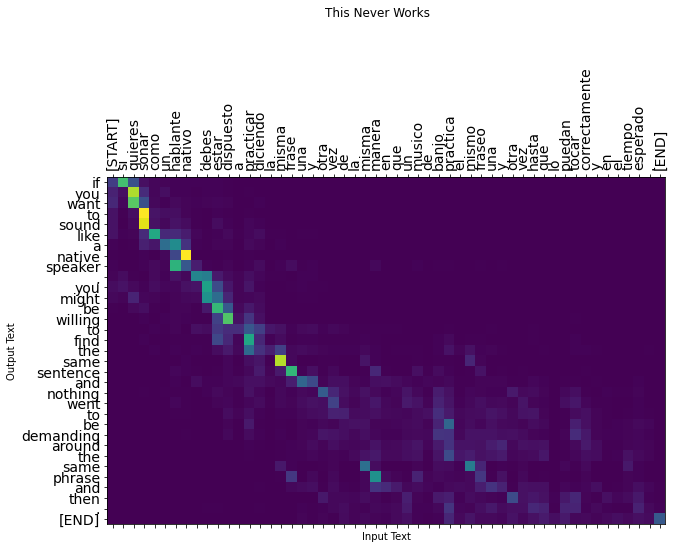

In [114]:
result = translator.tf_trasnlate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This Never Works')

In [115]:
tf.saved_model.save(
    translator,
    'models/translator',
    signatures={'serving_default': translator.tf_trasnlate}
)

INFO:tensorflow:Assets written to: models/translator\assets


INFO:tensorflow:Assets written to: models/translator\assets


In [117]:
reloaded = tf.saved_model.load('models/translator')

In [119]:
result = reloaded.tf_trasnlate(three_input_text)

In [120]:
%%time
result = reloaded.tf_trasnlate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

this is my life .
are you still at home ?
we will try to discover .
CPU times: total: 141 ms
Wall time: 120 ms
